In [3]:
from pandas import json_normalize
import pandas as pd
import json
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from tqdm.notebook import tqdm


def flattened_idx_to_layer_head(flattened_idx, num_heads):
    return flattened_idx // num_heads, flattened_idx % num_heads

def layer_head_to_flattened_idx(layer, head, num_heads):
    return layer * num_heads + head

In [4]:
df = pd.read_json("requirements_data/dataframe_open_chat_cot_moon_06022024_attentions_gt.json")

df.reset_index(drop=True, inplace=True)
correct = [0 if value == "yes" else 1 for value in df.predict.values]
df.correct = correct

In [5]:
from dataclasses import dataclass
import numpy as np
@dataclass
class Args:
    #model_name: str
    #dataset_name: str
    #activations_dataset: str
    val_ratio: float
    use_center_of_mass: bool
    use_random_dir: bool
    seed: int
    num_heads: int

args = Args(val_ratio=0.5, use_center_of_mass=False, use_random_dir=False, seed=42, num_heads=12)

num_layers =32
num_heads = 32

seed = 42

import numpy as np 

index_dic = {}
separated_activations = []
separated_labels = []
reqs_order = []
for req_id in df['req_id'].unique():

    req_df = df[df['req_id'] == req_id].index

    #req_ids.append(req_df)
    index_dic[req_id] = list(req_df)
    
    temp_activations = df[df['req_id'] == req_id].attentions
    activations = np.array([list(sample.values()) for sample in temp_activations.values])#.shape
    batch_length = len(temp_activations)
    dim = 128
    activations = np.reshape(activations, (batch_length, 32, 32, dim))

    temp_labels = [1 if label==True else 0 for label in df[df['req_id'] == req_id]['correct'].values]
    separated_labels.append(temp_labels)
    separated_activations.append(activations)
    reqs_order.append(req_id)

number_of_examples = np.arange(len(reqs_order))


fold_results = []
fold_probes = []

# get two folds using numpy
num_fold = 1
fold_idxs = np.array_split(number_of_examples, num_fold)
for i in range(len(fold_idxs)):
    print(i)
    if num_fold == 1: 
        train_idxs = np.arange(len(reqs_order))
    else:
        train_idxs = np.concatenate([fold_idxs[j] for j in range(num_fold) if j != i])

    val_ratio = args.val_ratio
    seed = 42  # You can choose your own seed value
    rng = np.random.default_rng(seed)
    size = int(len(train_idxs)*(1-val_ratio))
    #print(size)
    train_set_idxs = rng.choice(train_idxs, size=size, replace=False)
    val_set_idxs = np.array([x for x in train_idxs if x not in train_set_idxs])

    if len(fold_idxs) == 1:
        test_idxs = val_set_idxs
    else:
        test_idxs = fold_idxs[i]

    print(fold_idxs)
    print(train_idxs)
    print("Train indexes:" , train_set_idxs)
    print("Validation indexes: ", val_set_idxs)
    #print(test_idxs)

    # train_index_list = np.concatenate([list(index_dic.values())[i] for i in train_set_idxs], axis = 0)
    # train_set = df.loc[train_index_list]

    # rng = np.random.default_rng(seed)
    # val_idxs = val_set_idxs
    # probes, all_head_accs_np, train_accs = train_probes(seed, train_set_idxs, val_idxs, separated_activations , separated_labels, num_layers=num_layers, num_heads=num_heads)
    # fold_probes.append(probes)
    # fold_results.append(all_head_accs_np)

0
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Train indexes: [17 34  5 31 38 25  4  1 15 18 24  2 39 22 29 32 28 10 19 16]
Validation indexes:  [ 0  3  6  7  8  9 11 12 13 14 20 21 23 26 27 30 33 35 36 37]


In [6]:
def calculate_snr(set1, set2):

    # Assuming set1 and set2 are your two classes of data
    mean1 = np.mean(set1, axis=0)
    mean2 = np.mean(set2, axis=0)

    # Between-class variance (squared difference between class means)
    between_class_variance = np.sum((mean1 - mean2) ** 2)

    # Within-class variances (average variance within each class)
    within_class_variance = (np.var(set1, axis=0).mean() + np.var(set2, axis=0).mean()) / 2

    # Ratio similar to Fisher's criterion but without projection
    ratio = between_class_variance / within_class_variance#
    return ratio


def calculate_noise(set1,set2):

    # Within-class variances (average variance within each class)
    within_class_variance = (np.var(set1, axis=0).mean() + np.var(set2, axis=0).mean()) / 2

    within_class_variance = (np.var(set1, axis=0).mean())#+ np.var(set2, axis=0).mean()) / 2


    return within_class_variance



In [7]:
ratios = []
separated_head_wise_activations = separated_activations

all_X_train = np.concatenate([separated_head_wise_activations[i] for i in train_set_idxs], axis = 0)
print(all_X_train.shape)
all_X_val = np.concatenate([separated_head_wise_activations[i] for i in val_set_idxs], axis = 0)
y_train = np.concatenate([separated_labels[i] for i in train_set_idxs], axis = 0)
print(y_train.shape)
y_val = np.concatenate([separated_labels[i] for i in val_set_idxs], axis = 0)

for layer in tqdm(range(num_layers)): 
    for h in range(num_heads): 
            
            label =1
            indexes_yes = np.where(y_train == label)[0]
            ##indexes_val = np.where(y_val == 1)[0]
            #indexes = np.concatenate([indexes_train, indexes_val])
            
            ## needs to be split
            set1 = all_X_train[indexes_yes,layer,h,:]
            
            label =0
            indexes_no = np.where(y_train == label)[0]
            set2 = all_X_train[indexes_no,layer,h,:]

            # Assuming set1 and set2 are your two classes of data
            mean1 = np.mean(set1, axis=0)
            mean2 = np.mean(set2, axis=0)

            # Between-class variance (squared difference between class means)
            between_class_variance = np.sum((mean1 - mean2) ** 2)

            # Within-class variances (average variance within each class)
            within_class_variance = (np.var(set1, axis=0).mean() + np.var(set2, axis=0).mean()) / 2

            # Ratio similar to Fisher's criterion but without projection
            ratio = between_class_variance / within_class_variance

            ratios.append(ratio)

ratios = np.array(ratios)

(116, 32, 32, 128)
(116,)


  0%|          | 0/32 [00:00<?, ?it/s]

In [8]:
def remove_outliers(tuning_data, filter_data, labels):

    # Calculate mean and standard deviation
    means = tuning_data.mean(axis=0)
    stds = tuning_data.std(axis=0)

    # Calculate z-scores
    z_scores = np.abs((filter_data - means) / stds)

    # Set a threshold
    threshold = 4

    # Find where all features have a z-score less than the threshold
    non_outliers = (z_scores < threshold).all(axis=1)

    # Filter out the outliers
    filtered_data = filter_data[non_outliers]
    filter_labels = labels[non_outliers]
    #print(filter_data.shape)
    #print(filter_labels.shape)
    return filtered_data, filter_labels

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardizing the data
scaler = StandardScaler()

all_X_train = np.concatenate([separated_activations[i] for i in train_set_idxs], axis = 0)
#print(all_X_train.shape)
all_X_val = np.concatenate([separated_activations[i] for i in val_set_idxs], axis = 0)
y_train = np.concatenate([separated_labels[i] for i in train_set_idxs], axis = 0)
#print(y_train.shape)
y_val = np.concatenate([separated_labels[i] for i in val_set_idxs], axis = 0)
        
X_train = all_X_train[:,layer,h,:]
X_train.shape

X_val = all_X_val[:,layer,h,:]
X_val.shape

ratios = []

for layer in tqdm(range(num_layers)): 
    for h in range(num_heads): 
        
        y_train = np.concatenate([separated_labels[i] for i in train_set_idxs], axis = 0)
        #print(y_train.shape)
        y_val = np.concatenate([separated_labels[i] for i in val_set_idxs], axis = 0)
                

        X_train = all_X_train[:,layer,h,:]
        X_train.shape

        X_val = all_X_val[:,layer,h,:]
        X_val.shape

        scaler = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_val = scaler.transform(X_val)


        X_val, y_val = remove_outliers(X_train, X_val, y_val)
        
        X_train, y_train = remove_outliers(X_train, X_train, y_train)

        #cl = TSNE(n_components=2, random_state=args.seed).fit(X_train)
        cl = PCA(n_components=2, random_state=args.seed).fit(X_train)
        X_reduction = cl.transform(X_train)
        X_val_reduction = cl.transform(X_val)
        

        # scaler = scaler.fit(X_reduction)
        # X_reduction = scaler.transform(X_reduction)
        # X_val = scaler.transform(X_val_reduction)

        indexes_val = np.where(y_val == True)[0]
        samples_1 = [X_val_reduction[i] for i in indexes_val]

        indexes_val = np.where(y_val == False)[0]
        samples_2 = [X_val_reduction[i] for i in indexes_val]

        #print(str(head))
        #print(calculate_snr(samples_1, samples_2))
        #ratios.append(calculate_snr(samples_1, samples_2))
        ratios.append(calculate_noise(samples_1, samples_2))

ratios = np.array(ratios)

  0%|          | 0/32 [00:00<?, ?it/s]

9.340206048907895
2.304984392710187
12.720938294577394
5.999705188889213
1.5593843190961338


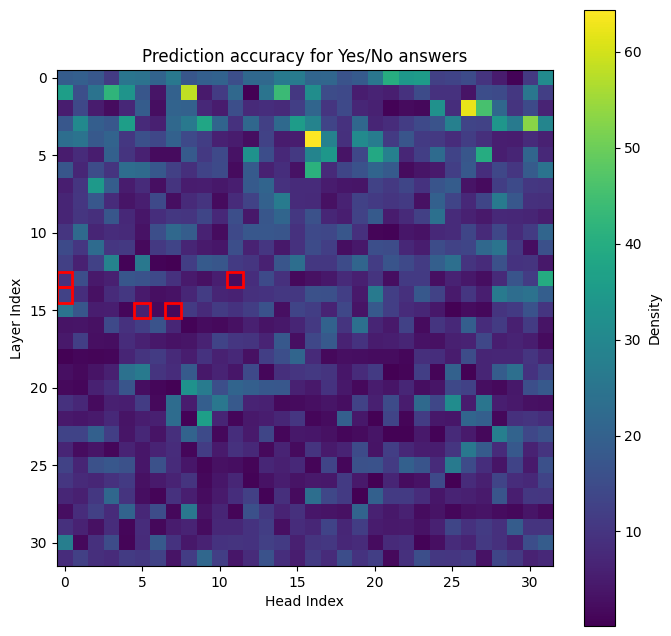

In [10]:
from matplotlib.patches import Rectangle
from matplotlib import pyplot as plt
#data = np.random.rand(10,10) # Example data

data = ratios.reshape(32,32) # np.random.rand(32, 32)  # Example data

fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.imshow(data, cmap='viridis', interpolation='nearest')

heads = [(13, 0), (13, 11), (14, 0), (15, 5), (15, 7)]


#x, y = 5, 5  # for example, highlighting the field at (5, 5)
for head in heads: 
    # Coordinates of the field you want to highlight
    # Note: Matplotlib's coordinate system starts from the top left corner as (0, 0)
    x = head[1]
    y = head[0]
    print(data[head[0], head[1]])
    # Create a rectangle outline
    # Arguments: (x, y) - lower left corner, width, height, edgecolor, and fill
    rect = Rectangle((x-0.5, y-0.5), 1, 1, linewidth=2, edgecolor='r', facecolor='none')

    # Add the rectangle to the Axes
    ax.add_patch(rect)

# Add a colorbar associated with the Axes object's content
fig.colorbar(cax, ax=ax, label='Density')

# Set titles and labels
ax.set_title('Prediction accuracy for Yes/No answers')
ax.set_xlabel('Head Index')
ax.set_ylabel('Layer Index')

plt.show()

1.5714218022589554
1.4208694978942533
5.956924371218628
1.142746278399323
0.835726738740993


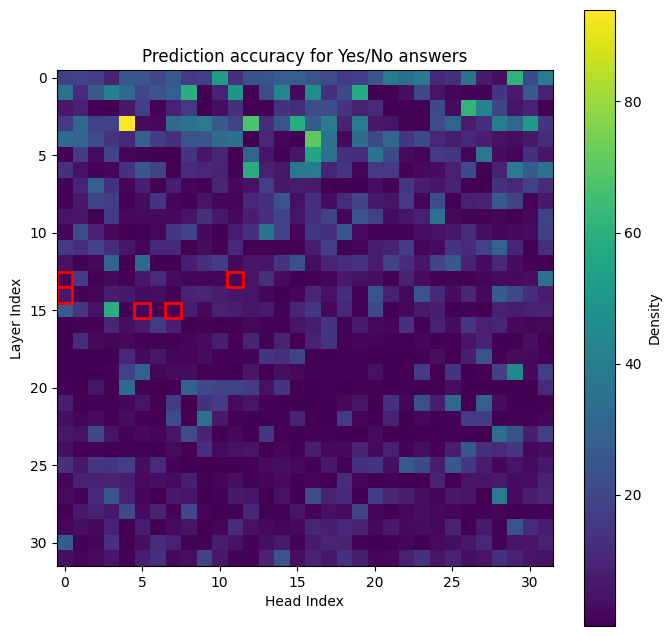

In [15]:
from matplotlib.patches import Rectangle
from matplotlib import pyplot as plt
#data = np.random.rand(10,10) # Example data

data = ratios.reshape(32,32) # np.random.rand(32, 32)  # Example data

fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.imshow(data, cmap='viridis', interpolation='nearest')

heads = [(13, 0), (13, 11), (14, 0), (15, 5), (15, 7)]


#x, y = 5, 5  # for example, highlighting the field at (5, 5)
for head in heads: 
    # Coordinates of the field you want to highlight
    # Note: Matplotlib's coordinate system starts from the top left corner as (0, 0)
    x = head[1]
    y = head[0]
    print(data[head[0], head[1]])
    # Create a rectangle outline
    # Arguments: (x, y) - lower left corner, width, height, edgecolor, and fill
    rect = Rectangle((x-0.5, y-0.5), 1, 1, linewidth=2, edgecolor='r', facecolor='none')

    # Add the rectangle to the Axes
    ax.add_patch(rect)

# Add a colorbar associated with the Axes object's content
fig.colorbar(cax, ax=ax, label='Density')

# Set titles and labels
ax.set_title('Prediction accuracy for Yes/No answers')
ax.set_xlabel('Head Index')
ax.set_ylabel('Layer Index')

plt.show()

(13, 0)
1.2484125799065566
(13, 11)
3.91554345967666
(15, 5)
11.26262604063171
(15, 6)
10.176149595868216
(15, 7)
2.8545737002952847
(11, 17)
1.5948693459860352
(31, 20)
2.0900498798074123
(31, 14)
5.598253798474469
(31, 7)
2.4159161119809993


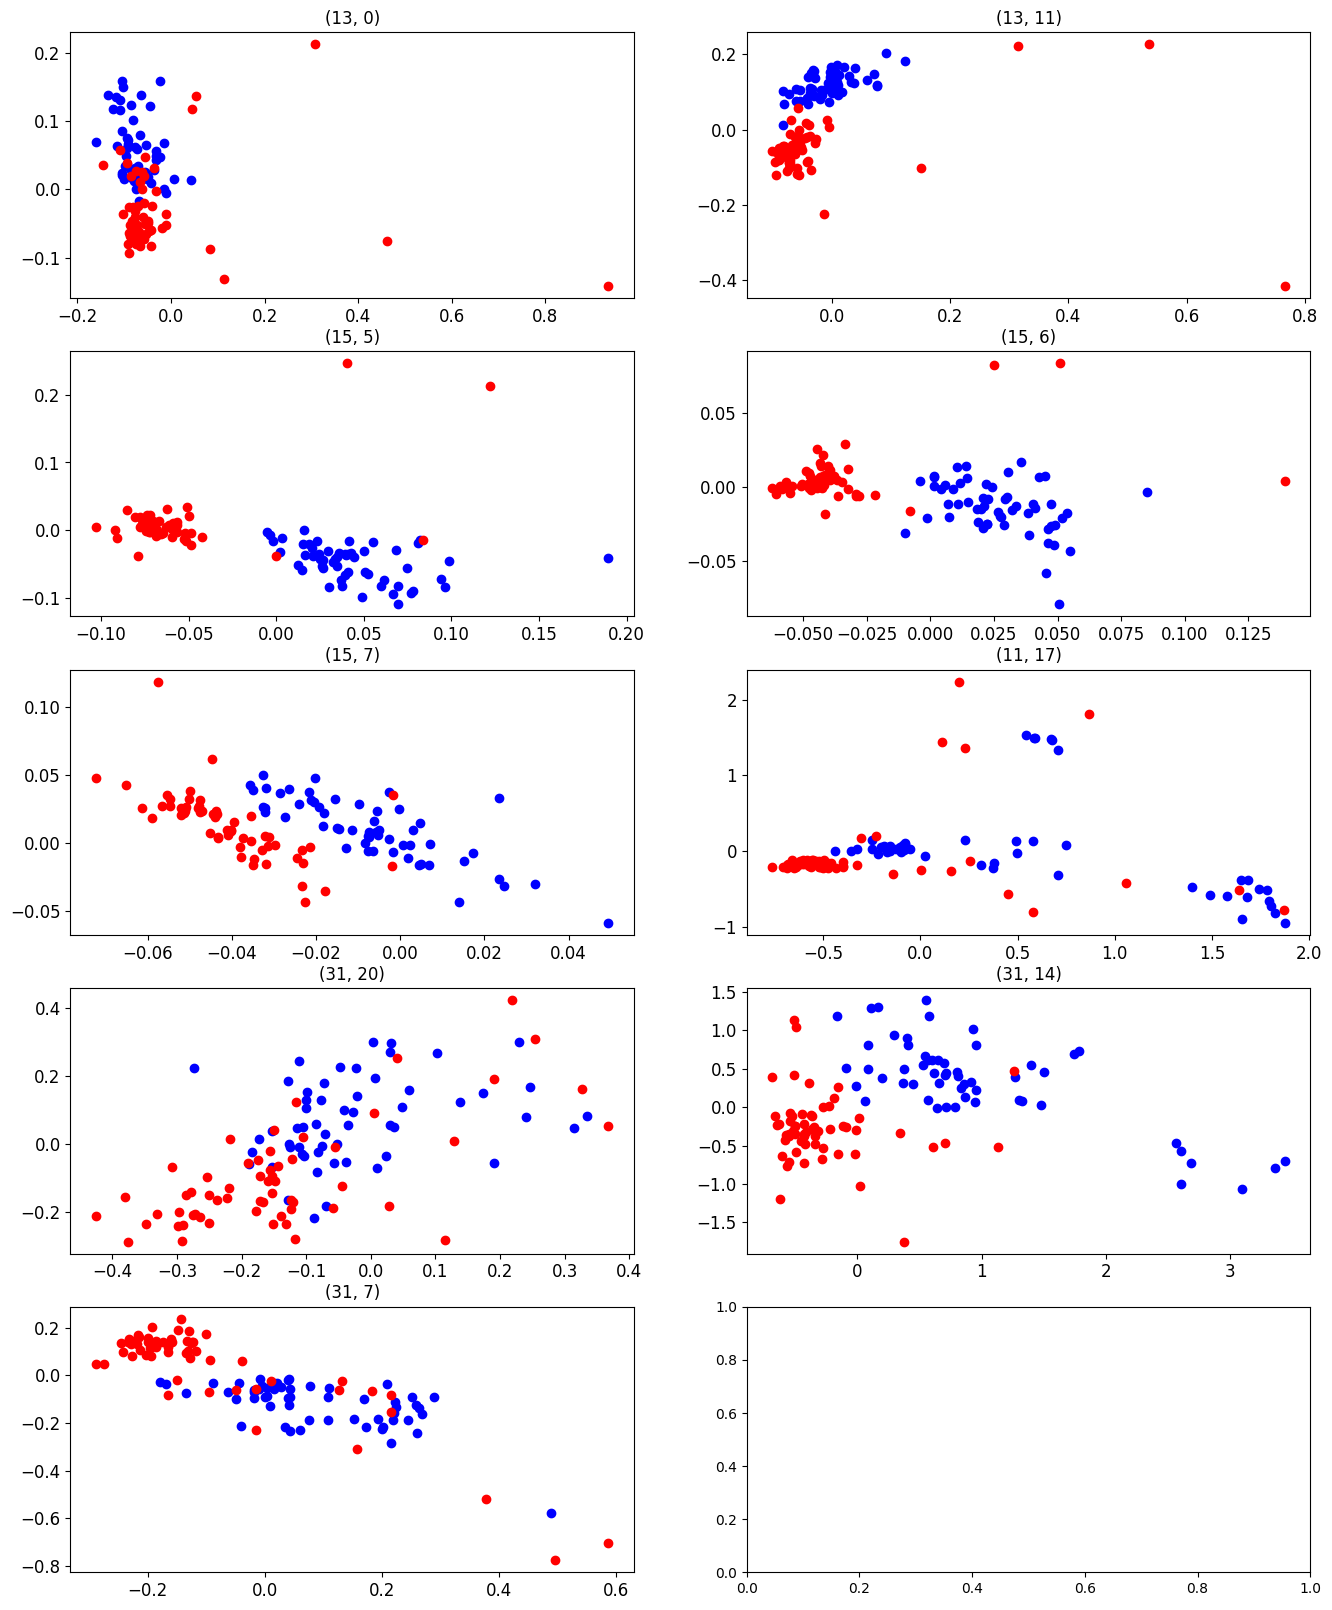

In [10]:
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
#heads = [(2,5), (3,9), (7,24), (10,23), (13,0), (13,11),(14,0), (15,5), (15,6), (15,7), (17,10),(17,20), (31,14), (17, 23)]#,# (3,14)]#(11,8), (8,24), (7,24)]
heads = [(13,0), (13, 11),(15,5), (15,6), (15,7), (11,17), (31,20), (31,14), (31,7)] #(3,4), (17, 11), (9,10) ,  (17,22) , (16,8),
#heads = [(13, 0), (13, 8), (13, 11), (0, 31), (1, 0), (3, 9), (7, 24), (10, 23), (15, 2), (17, 23), (28, 8), (30, 0), (31, 13), (31, 14), (31, 28), (31, 30)]
#heads = [(28, i) for i in range(0,32)]
#for head in heads:

## 14 0 14 10 15 5 15 6 15 7 16 6 17 20
n_rows = len(heads) // 2 + 1
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(16, 20))

for id, head in enumerate(heads):

    ax = fig.axes[id] 
    ax.set_title(str(head))
    layer = head[0]
    h = head[1]
    all_X_train = np.concatenate([separated_activations[i] for i in train_set_idxs], axis = 0)
    #print(all_X_train.shape)
    all_X_val = np.concatenate([separated_activations[i] for i in val_set_idxs], axis = 0)
    y_train = np.concatenate([separated_labels[i] for i in train_set_idxs], axis = 0)
    #print(y_train.shape)
    y_val = np.concatenate([separated_labels[i] for i in val_set_idxs], axis = 0)
            
    X_train = all_X_train[:,layer,h,:]
    X_train.shape

    X_val = all_X_val[:,layer,h,:]
    X_val.shape

    # # Standardizing the data
    # scaler = StandardScaler()
    # scaler = scaler.fit(X_train)
    # X_train = scaler.transform(X_train)
    # X_val = scaler.transform(X_val)


    # # Filtering for outliers
    # X_val, y_val = remove_outliers(X_train, X_val, y_val)
    # X_train, y_train = remove_outliers(X_train, X_train, y_train)

    #cl = TSNE(n_components=2, random_state=args.seed).fit(X_train)
    cl = PCA(n_components=2, random_state=args.seed).fit(X_train)
    X_reduction = cl.transform(X_train)
    X_val_reduction = cl.transform(X_val)
    
    indexes_val = np.where(y_val == True)[0]
    samples_1 = [X_val_reduction[i] for i in indexes_val]

    indexes_val = np.where(y_val == False)[0]
    samples_2 = [X_val_reduction[i] for i in indexes_val]

    # indexes_val = np.where(y_train == True)[0]
    # samples_1 = [X_reduction[i] for i in indexes_val]

    # indexes_val = np.where(y_train == False)[0]
    # samples_2 = [X_reduction[i] for i in indexes_val]
    print(str(head))
    print(calculate_snr(samples_1, samples_2))

    for label, color in zip([True, False], ['blue', 'red']):

        #color = ['blue', 'red']
        #    ax.scatter(X_reduction[:,0], X_reduction[:,1], c=color[0])#, label=str(label))

        #ax.scatter(X_val_reduction[:,0], X_val_reduction[:,1], c=color[1])
        #indexes_train = np.where(y_train == label)[0]
        indexes_val = np.where(y_val == label)[0]
            #indexes = np.concatenate([indexes_train, indexes_val])
        
        samples = [X_val_reduction[i] for i in indexes_val]

        for idx in indexes_val:
            #for i, idx in enumerate(df_reduced[indices_to_keep].index):
                #if idx in df_reduced[df_reduced['req_id'].isin(filt)].index :
                #ax.text(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], str(idx))
                            #print(idx)
                #if idx in df_reduced[true_false].index:
            #ax.scatter(X_reduction[idx,0], X_reduction[idx, 1], c=color, label=str(idx))
            ax.scatter(X_val_reduction[idx,0], X_val_reduction[idx, 1], c=color, label=str(idx))
            #ax.scatter(X_reduction[idx,0], 1, c=color, label=str(idx))
            #ax.hist(X_reduction[idx,0], bins=35, color=color, alpha=0.4, label=str(idx))  # Histogram
    # Adjusting tick label font sizes using tick_params
    ax.tick_params(axis='x', labelsize=12)  # Adjust font size for x-axis tick labels
    ax.tick_params(axis='y', labelsize=12)  # Adjust font size for y-axis tick labels
    
                     

In [ ]:
ratios = []
separated_head_wise_activations = separated_activations


all_X_train = np.concatenate([separated_head_wise_activations[i] for i in train_set_idxs], axis = 0)
print(all_X_train.shape)
all_X_val = np.concatenate([separated_head_wise_activations[i] for i in val_set_idxs], axis = 0)
y_train = np.concatenate([separated_labels[i] for i in train_set_idxs], axis = 0)
print(y_train.shape)
y_val = np.concatenate([separated_labels[i] for i in val_set_idxs], axis = 0)

for layer in tqdm(range(num_layers)): 
        for h in range(num_heads): 
                
                label =1
                indexes_yes = np.where(y_train == label)[0]
                ##indexes_val = np.where(y_val == 1)[0]
                #indexes = np.concatenate([indexes_train, indexes_val])

                
                ## needs to be split
                set1 = all_X_train[indexes_yes,layer,h,:]
                
                label =0
                indexes_no = np.where(y_train == label)[0]
                set2 = all_X_train[indexes_no,layer,h,:]

                # Assuming set1 and set2 are your two classes of data
                mean1 = np.mean(set1, axis=0)
                mean2 = np.mean(set2, axis=0)

                # Between-class variance (squared difference between class means)
                between_class_variance = np.sum((mean1 - mean2) ** 2)

                # Within-class variances (average variance within each class)
                within_class_variance = (np.var(set1, axis=0).mean() + np.var(set2, axis=0).mean()) / 2

                # Ratio similar to Fisher's criterion but without projection
                ratio = between_class_variance / within_class_variance

                ratios.append(ratio)

ratios = np.array(ratios)

In [ ]:
 ## needs to be split
# set1 = all_X_train[indexes_yes,layer,h,:]

# label =0
# indexes_no = np.where(y_train == label)[0]
# set2 = all_X_train[indexes_no,layer,h,:]

layer = 3
h = 9

X_train = all_X_train[:,layer,h,:]
X_train.shape

X_val = all_X_val[:,layer,h,:]
X_val.shape

#cl = TSNE(n_components=2, random_state=args.seed).fit(X_train)
cl = PCA(n_components=2, random_state=args.seed).fit(X_train)
X_reduction = cl.transform(X_train)
X_val_reduction = cl.transform(X_val)


indexes_val = np.where(y_val == True)[0]
samples_1 = [X_val_reduction[i] for i in indexes_val]

indexes_val = np.where(y_val == False)[0]
samples_2 = [X_val_reduction[i] for i in indexes_val]

set1 = samples_1
set2 = samples_2

# Assuming set1 and set2 are your two classes of data
mean1 = np.mean(set1, axis=0)
mean2 = np.mean(set2, axis=0)

print("Mean True", mean1)
print("Mean False", mean2)

print("Variance True", np.var(set1, axis=0).mean())
print("Variance False", np.var(set2, axis=0).mean())

print("Summed_ Variance:",np.var(set1, axis=0).mean() + np.var(set2, axis=0).mean())

# Between-class variance (squared difference between class means)
between_class_variance = np.sum((mean1 - mean2) ** 2)

# Within-class variances (average variance within each class)
within_class_variance = (np.var(set1, axis=0).mean() + np.var(set2, axis=0).mean()) / 2

# Ratio similar to Fisher's criterion but without projection
ratio = between_class_variance / within_class_variance#
print("Ratio", ratio)